In [3]:
import os.path as op
import mne
import numpy as np
from mne.datasets import fetch_fsaverage
from mne.minimum_norm import make_inverse_operator, apply_inverse,apply_inverse_raw, apply_inverse_epochs
import numpy as np

In [4]:

raw=mne.io.read_raw_fif('SG02/'+'SG02_motor_clean.fif',preload=True)
stim_initial= np.genfromtxt('SG02/SG02_motor_clean_marks.csv', delimiter=',')


Opening raw data file SG02/SG02_motor_clean.fif...
    Range : 0 ... 93249 =      0.000 ...   372.996 secs
Ready.
Reading 0 ... 93249  =      0.000 ...   372.996 secs...


<ipython-input-4-cdfe3435136a>:1: RuntimeWarning: This filename (SG02/SG02_motor_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('SG02/'+'SG02_motor_clean.fif',preload=True)


In [5]:
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)
subject='fsaverage'

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage


In [6]:
def all_about_forward(raw,subjects_dir,subject='fsaverage'):
    

    subject = 'fsaverage'
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
    bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
    
    montage = mne.channels.make_standard_montage('standard_1005')
    
    dic={}

    for i in range(len(raw.ch_names)):

        kek=raw.ch_names[i].replace('.','').upper()
        kek=kek.replace('Z','z')
        kek=kek.replace('FP1','Fp1')
        kek=kek.replace('FP2','Fp2')
        kek=kek.replace('FPz','Fpz')
        dic[raw.ch_names[i]]=kek
    
    
    raw.rename_channels(mapping=dic)
    raw.set_montage(montage)
    raw.set_eeg_reference(projection=True)
    events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

    cov = mne.compute_raw_covariance(raw)

    fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                    bem=bem, eeg=True, mindist=5.0, n_jobs=1)
    #print(fwd)

    # Use fwd to compute the sensitivity map for illustration purposes
    
    cov = mne.compute_raw_covariance(raw)

    
    
    return raw,cov,fwd

In [7]:

fs_dir='SG02_anatomy/SG02'
subject = 'SG02'
trans = None  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'SG02-ico5-src.fif')
bem = op.join(fs_dir, 'bem', 'SG02-bem.fif')

In [8]:
montage = mne.channels.make_standard_montage('standard_1005')


In [10]:
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)


<ipython-input-10-983d1cadfdab>:2: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference(projection=True)


<Raw | SG02_motor_clean.fif, 30 x 93250 (373.0 s), ~21.4 MB, data loaded>

In [11]:
cov_data = np.identity(30)

cov = mne.Covariance(
        cov_data, raw.info.ch_names, raw.info["bads"], raw.info["projs"], nfree=1
)



In [12]:
fwd = mne.make_forward_solution(raw.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=1)

Source space          : SG02_anatomy/SG02\bem\SG02-ico5-src.fif
MRI -> head transform : identity
Measurement data      : instance of Info
Conductor model   : SG02_anatomy/SG02\bem\SG02-bem.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading SG02_anatomy/SG02\bem\SG02-ico5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00

Read  30 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM model using SG02_anatomy/SG02\bem\SG02-bem.fif...

Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear_collocation BEM solution from C:\Users\CBI\Desktop\Untitled Folder\SG0

In [13]:
inv = make_inverse_operator(raw.info, fwd, cov, loose=0., depth=0.8,
                            verbose=True)

Computing inverse operator with 30 channels.
    30 out of 30 channels remain after picking
Selected 30 channels
Creating the depth weighting matrix...
    30 EEG channels
    limit = 20474/20473 = 5.484700
    scale = 65199.4 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 6.7e-05 (2.2e-16 eps * 30 dim * 1e+10  max singular value)
    Estimated rank (eeg): 29
    EEG: rank 29 computed from 30 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest 

In [14]:
raw_example=raw.copy().crop(0,20)

In [15]:
def events_matrix_from_list(stim_initial):
    events_matrix=[]
    for i in range(1,len(stim_initial)):
        if stim_initial[i]!=stim_initial[i-1]:
            events_matrix.append([i,0,str(int(stim_initial[i]))])
        
    events_matrix=np.array(events_matrix)
    
    return events_matrix.astype(int)

In [16]:
tmin, tmax = 0., 6.
events_matrix=events_matrix_from_list(stim_initial)
event_id=[2,3,4,5,6,7]

#real epochs of eeg data
epochs = mne.Epochs(raw, events_matrix, event_id, tmin, tmax, proj=True,
                baseline=None, preload=True)

Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 80 events and 1501 original time points ...
1 bad epochs dropped


In [17]:
'Rest':2 , 'Left leg':4 ,  'Right leg':5, 'Left hand':6,'Right hand':7}

SyntaxError: invalid syntax (<ipython-input-17-fa02d1c2072c>, line 1)

In [18]:
import matplotlib.pyplot as plt

In [19]:
epochs_rest=epochs['2'].copy()
epochs_rest.filter(7,13)

Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 sec)



Number of events,8
Events,2: 8
Time range,0.000 – 6.000 sec
Baseline,off


In [20]:
snr = 3.0
lambda2 = 1.0 / snr ** 2
kwargs = dict(initial_time=0.08, hemi='both', subjects_dir=subjects_dir,
              size=(600, 600))

#stc = abs(apply_inverse_raw(raw_example, inv, lambda2, 'MNE', verbose=True))

stc = apply_inverse_epochs(epochs_rest, inv, lambda2, 'MNE', verbose=True)[0]
brain = stc.plot(figure=1, initial_time=0.08, hemi='both', subjects_dir=subjects_dir, colorbar=False)
brain.add_text(0.1, 0.9, 'MNE', 'title', font_size=14)


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 8
Processing epoch : 2 / 8
Processing epoch : 3 / 8
Processing epoch : 4 / 8
Processing epoch : 5 / 8
Processing epoch : 6 / 8
Processing epoch : 7 / 8
Processing epoch : 8 / 8
[done]
Using pyvista 3d backend.

Using control points [1.49877447e-11 1.74831489e-11 4.61577268e-11]


FileNotFoundError: File does not exist: C:\Users\CBI\mne_data\MNE-fsaverage-data\SG02\surf\lh.inflated

In [24]:
stc

<SourceEstimate | 20473 vertices, subject : SG02, tmin : 0.0 (ms), tmax : 6000.0 (ms), tstep : 4.0 (ms), data shape : (20473, 1501), ~234.6 MB>

In [25]:
epochs_right_hand=epochs['7'].copy()
epochs_right_hand.filter(7,13)

Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 sec)



Number of events,8
Events,7: 8
Time range,0.000 – 6.000 sec
Baseline,off


In [26]:
stc = apply_inverse_epochs(epochs_right_hand, inv, lambda2, 'MNE', verbose=True)[1]
brain = stc.plot(figure=1, initial_time=0.08, hemi='both', subjects_dir=subjects_dir, colorbar=False)
brain.add_text(0.1, 0.9, 'MNE', 'title', font_size=14)



Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 8
Processing epoch : 2 / 8
Processing epoch : 3 / 8
Processing epoch : 4 / 8
Processing epoch : 5 / 8
Processing epoch : 6 / 8
Processing epoch : 7 / 8
Processing epoch : 8 / 8
[done]
Using control points [1.09599279e-11 1.25474867e-11 2.74344593e-11]


FileNotFoundError: File does not exist: C:\Users\CBI\mne_data\MNE-fsaverage-data\SG02\surf\lh.inflated

In [27]:
epochs_left_hand=epochs['6'].copy()
epochs_left_hand.filter(7,13)

Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 sec)



Number of events,8
Events,6: 8
Time range,0.000 – 6.000 sec
Baseline,off


In [87]:
lambda2

0.1111111111111111

In [90]:
stc = apply_inverse_epochs(epochs_left_hand, inv, lambda2, 'MNE', verbose=True)[1]
brain = stc.plot(figure=1, initial_time=0.08, hemi='both', subjects_dir=subjects_dir, colorbar=False)
brain.add_text(0.1, 0.9, 'MNE', 'title', font_size=14)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 8
Processing epoch : 2 / 8
Processing epoch : 3 / 8
Processing epoch : 4 / 8
Processing epoch : 5 / 8
Processing epoch : 6 / 8
Processing epoch : 7 / 8
Processing epoch : 8 / 8
[done]
Using control points [1.74540327e-11 2.01234683e-11 4.85174295e-11]


### Смотрю как работает преобразование гильберта

In [108]:
epochs_hilbert=epochs.copy()
epochs_non_hilbert=epochs.copy()


In [109]:
epochs_hilbert.apply_hilbert(envelope=True)

Number of events,79
Events,2: 83: 394: 85: 86: 87: 8
Time range,0.000 – 6.000 sec
Baseline,off


In [110]:
epochs_hilbert.get_data().shape

(79, 30, 1501)

In [106]:
epochs_non_hilbert.get_data().shape

(79, 30, 1501)

In [114]:
%matplotlib qt5

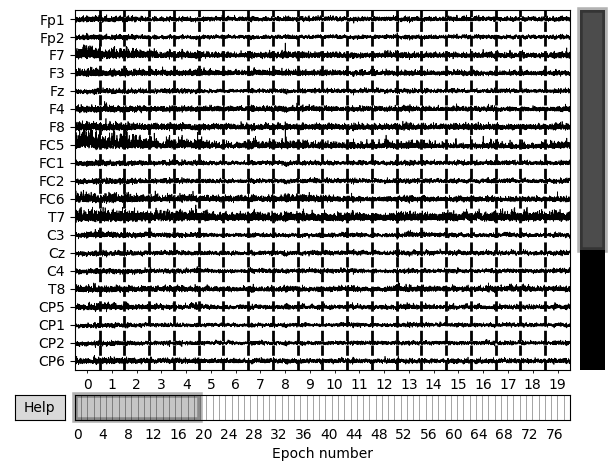

In [115]:
epochs_hilbert.plot()

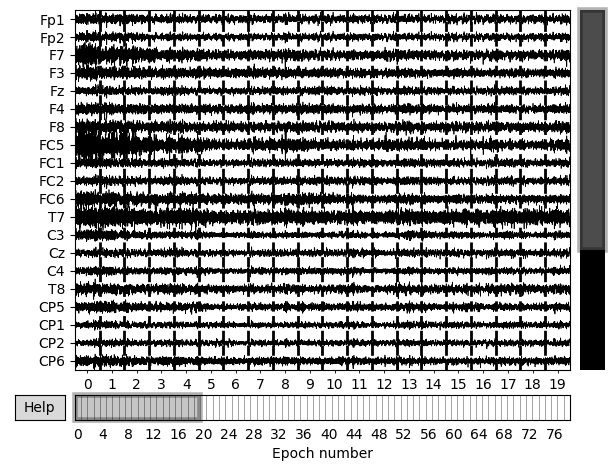

Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none


In [116]:
epochs_non_hilbert.plot()

### PSD

In [28]:
from mne.minimum_norm import compute_source_psd_epochs

In [30]:
subjects_dir

'C:\\Users\\CBI\\mne_data\\MNE-fsaverage-data'

In [32]:
labels=mne.read_labels_from_annot(subject, 
                               parc='aparc', 
                               hemi='both', 
                               surf_name='pial', 
                               annot_fname=None, 
                               regexp=None, 
                               subjects_dir='SG02_anatomy', 
                               #sort=True, 

                                  verbose=None)

Reading labels from parcellation...
   read 34 labels from SG02_anatomy\SG02\label\lh.aparc.annot
   read 34 labels from SG02_anatomy\SG02\label\rh.aparc.annot


In [33]:
labels[48]

<Label | SG02, 'precentral-lh', lh : 6684 vertices>

In [34]:
#labels_to_plot=[labels[48], labels[49]]

labels_to_plot=labels[44]
labels_to_plot=labels[48]

In [35]:
labels_to_plot

<Label | SG02, 'precentral-lh', lh : 6684 vertices>

In [36]:
epochs_psd_rest=epochs['2'].copy()
epochs_psd_right_hand=epochs['7'].copy()
epochs_psd_left_hand=epochs['6'].copy()

In [37]:
bandwidth = 4

In [38]:
epochs_psd_rest

Number of events,8
Events,2: 8
Time range,0.000 – 6.000 sec
Baseline,off


In [39]:

stcs = compute_source_psd_epochs(epochs_psd_rest, inv,
                                 lambda2=lambda2,
                                 method='MNE', fmin=3, fmax=30,
                                 bandwidth=bandwidth, label=labels_to_plot,
                                 return_generator=True, verbose=True)

# compute average PSD over the first 10 epochs
psd_avg = 0.
for i, stc in enumerate(stcs):
    psd_avg += stc.data
psd_avg /= len(epochs_psd_rest)
freqs = stc.times  # the frequencies are stored here
stc.data = psd_avg  # overwrite the last epoch's data with the average

Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs


In [337]:
brain = stc.plot(initial_time=10., hemi='lh', views='lat',  # 10 HZ
                 clim=dict(kind='value', lims=(20, 40, 60)),
                 smoothing_steps=3, subjects_dir=subjects_dir)
brain.add_label(labels_to_plot, borders=True, color='k')

In [338]:
psd_avg.shape

(674, 162)

In [339]:
epochs_psd_right_hand.get_data().shape

(8, 30, 1501)

In [340]:

stcs = compute_source_psd_epochs(epochs_psd_right_hand, inv,
                                 lambda2=lambda2,
                                 method='MNE', fmin=3, fmax=30,
                                 bandwidth=bandwidth, label=labels_to_plot,
                                 return_generator=True, verbose=True)

# compute average PSD over the first 10 epochs
psd_avg = 0.
for i, stc in enumerate(stcs):
    psd_avg += stc.data
psd_avg /= len(epochs_psd_right_hand)
freqs = stc.times  # the frequencies are stored here
stc.data = psd_avg  # overwrite the last epoch's data with the average

Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs


In [341]:
brain = stc.plot(initial_time=10., hemi='lh', views='lat',  # 10 HZ
                 clim=dict(kind='value', lims=(20, 40, 60)),
                 smoothing_steps=3, subjects_dir=subjects_dir)
brain.add_label(labels_to_plot, borders=True, color='k')

In [342]:

stcs = compute_source_psd_epochs(epochs_psd_left_hand, inv,
                                 lambda2=lambda2,
                                 method='MNE', fmin=3, fmax=30,
                                 bandwidth=bandwidth, label=labels_to_plot,
                                 return_generator=True, verbose=True)

# compute average PSD over the first 10 epochs
psd_avg = 0.
for i, stc in enumerate(stcs):
    psd_avg += stc.data
psd_avg /= len(epochs_psd_right_hand)
freqs = stc.times  # the frequencies are stored here
stc.data = psd_avg  # overwrite the last epoch's data with the average

Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs


In [343]:
brain = stc.plot(initial_time=10., hemi='lh', views='lat',  # 10 HZ
                 clim=dict(kind='value', lims=(20, 40, 60)),
                 smoothing_steps=3, subjects_dir=subjects_dir)
brain.add_label(labels_to_plot, borders=True, color='k')

Text(0, 0.5, 'Power Spectral Density')

### Как меняет спектрограмма при разных значениях лямбды

In [60]:
labels_to_plot=labels[45]
labels_to_plot

<Label | SG02, 'postcentral-rh', rh : 5499 vertices>

In [61]:
fig, ax = plt.subplots()

lambdas=[0.001,0.01,0.05,0.1,0.4]

for i in lambdas:
    lambda2=i
    stcs = compute_source_psd_epochs(epochs_psd_rest, inv,
                                     lambda2=lambda2,
                                     method='MNE', fmin=3, fmax=30,
                                     bandwidth=bandwidth, label=labels_to_plot,
                                     return_generator=True, verbose=True)

    # compute average PSD over the first 10 epochs
    psd_avg = 0.
    for i, stc in enumerate(stcs):
        psd_avg += stc.data
    psd_avg /= len(epochs_psd_right_hand)
    freqs = stc.times  # the frequencies are stored here
    stc.data = psd_avg  # overwrite the last epoch's data with the average
    
    
    ax.plot(freqs, psd_avg.mean(axis=0),label=str(lambda2))
    
ax.set_xlabel('Freq (Hz)')
ax.set_xlim(stc.times[[0, -1]])
ax.set_ylabel('Power Spectral Density')
ax.legend()
ax.set_title('a')

Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs


Text(0.5, 1.0, 'a')

In [62]:
labels_to_plot

<Label | SG02, 'postcentral-rh', rh : 5499 vertices>

In [63]:
labels_to_plot=labels[49]
labels_to_plot

<Label | SG02, 'precentral-rh', rh : 6328 vertices>

In [52]:
%matplotlib qt5

In [64]:

lambdas=[0.001,0.01,0.05,0.1,0.4]

for i in lambdas:
    lambda2=i
    stcs = compute_source_psd_epochs(epochs_psd_rest, inv,
                                     lambda2=lambda2,
                                     method='MNE', fmin=3, fmax=30,
                                     bandwidth=bandwidth, label=labels_to_plot,
                                     return_generator=True, verbose=True)

    # compute average PSD over the first 10 epochs
    psd_avg = 0.
    for i, stc in enumerate(stcs):
        psd_avg += stc.data
    psd_avg /= len(epochs_psd_right_hand)
    freqs = stc.times  # the frequencies are stored here
    stc.data = psd_avg  # overwrite the last epoch's data with the average
    print(np.sum(stc.data))
    
    ax.plot(freqs, psd_avg.mean(axis=0),label=str(lambda2))
    
ax.set_xlabel('Freq (Hz)')
ax.set_xlim(stc.times[[0, -1]])
ax.set_ylabel('Power Spectral Density')
ax.legend()
plt.show()
ax.set_title('a')

Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



3.966669095938144e-16
Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



2.0464936754944817e-16
Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



9.178322937612644e-17
Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



6.264768969208696e-17
Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



2.9843626508114557e-17


Text(0.5, 1.0, 'a')

In [59]:
fig.show()

In [54]:
fig, ax = plt.subplots()

lambdas=[0.001,0.01,0.05,0.1,0.4]

for i in lambdas:
    lambda2=i
    stcs = compute_source_psd_epochs(epochs_psd_left_hand, inv,
                                     lambda2=lambda2,
                                     method='sLORETA', fmin=3, fmax=30,
                                     bandwidth=bandwidth, label=labels_to_plot,
                                     return_generator=True, verbose=True)

    # compute average PSD over the first 10 epochs
    psd_avg = 0.
    for i, stc in enumerate(stcs):
        psd_avg += stc.data
    psd_avg /= len(epochs_psd_right_hand)
    freqs = stc.times  # the frequencies are stored here
    stc.data = psd_avg  # overwrite the last epoch's data with the average
    
    
    ax.plot(freqs, psd_avg.mean(axis=0),label=str(lambda2)+' sLORETA')
    
ax.set_xlabel('Freq (Hz)')
ax.set_xlim(stc.times[[0, -1]])
ax.set_ylabel('Power Spectral Density')
ax.legend()

Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs



Considering frequencies 3 ... 30 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 30 -> 29
Using 23 tapers with bandwidth 4.0 Hz on 8 epochs


### Решить обартную задачу в области и с преобразованием гильберта

In [413]:
epochs_hilbert=epochs.copy()
epochs_non_hilbert=epochs.copy()
epochs_hilbert.filter(8,12)





Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 sec)



Number of events,79
Events,2: 83: 394: 85: 86: 87: 8
Time range,0.000 – 6.000 sec
Baseline,off


In [420]:
epochs_hilbert.apply_hilbert()

Number of events,79
Events,2: 83: 394: 85: 86: 87: 8
Time range,0.000 – 6.000 sec
Baseline,off


In [430]:
stcs = apply_inverse_epochs(epochs_hilbert, inv, lambda2=1. / 9., method= 'MNE', label=labels_to_plot)


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Picked 30 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 79
Processing epoch : 2 / 79
Processing epoch : 3 / 79
Processing epoch : 4 / 79
Processing epoch : 5 / 79
Processing epoch : 6 / 79
Processing epoch : 7 / 79
Processing epoch : 8 / 79
Processing epoch : 9 / 79
Processing epoch : 10 / 79
Processing epoch : 11 / 79
Processing epoch : 12 / 79
Processing epoch : 13 / 79
Processing epoch : 14 / 79
Processing epoch : 15 / 79
Processing epoch : 16 / 79
Processing epoch : 17 / 79
Processing epoch : 18 / 79
Processing epoch : 19 / 79
Processing epoch : 20 / 79
Processing epoch : 21 / 79
Processing epoch : 22 / 79
Processing epoch : 23 / 7

In [431]:
stcs = apply_inverse_raw(raw, inv, lambda2=1. / 9., method= 'MNE', label=labels_to_plot)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
Applying inverse to raw...
    Picked 30 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
[done]


In [432]:
raw

<Raw | SG02_motor_clean.fif, 30 x 93250 (373.0 s), ~21.4 MB, data loaded>

In [436]:
abs(stcs.data).shape

(671, 93250)

In [ ]:
stc = apply_inverse_epochs(epochs_left_hand, inv, lambda2, 'MNE', verbose=True)[1]
